In [2]:
# I need to clean these imports up

import numpy as np
import scipy
from scipy import special
from scipy import integrate
from scipy import interpolate
from scipy import stats
from scipy import optimize
from numpy.random import default_rng

import time, os

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Standardizing some of the font sizes for plots

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.family'] = 'serif'

# Some of Matt's matplotlib style settings

import matplotlib as mpl

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

from IPython import display
import sys

sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf\\torchkit")
sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf\\torchkit\\torchkit")
sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf")

import naf
import scipy as sp
import math

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn import init

from sklearn.preprocessing import RobustScaler,MinMaxScaler

<h1> Density Estimation via NAF </h1>

In [70]:
# Loading in a generated halo

loadHalo = True

if loadHalo == True:
    nfwHalo = np.load('generatedHalos//nfwGeneratedTracers_Apr_14_2021_1815.npz')

In [71]:
haloInfo = nfwHalo['arr_1']
genPhaseSpace = np.transpose(nfwHalo['arr_3'])

In [72]:
class EntropyDataset(Dataset):
    """Top tagging dataset."""

    def __init__(self,data):
        """
        Args:
            datfile (string): File containing all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data=data
        
#        self.images, self.labels = read_images(datfile,Nread)

    def __len__(self):
        self.len=len(self.data)
        return self.len

    def __getitem__(self, idx):
        datum = self.data[idx]

        return datum

In [73]:
train_set = EntropyDataset(genPhaseSpace)

In [74]:
my_batch_size=128

train_loader = DataLoader(train_set, batch_size=my_batch_size,
                        shuffle=True,pin_memory=True)
# BECAUSE THIS IS UNSUPERVISED DENSITY ESTIMATION WE USE THE SAME TEST=TRAIN SET
test_loader = DataLoader(train_set, batch_size=1000,
                        shuffle=False,pin_memory=True)

In [75]:
denaf = naf.DensityEstimator(flowtype=1,dim=6,lr=0.0001)

In [78]:
epochs = 30

In [77]:
denaf.fit(train_loader, save_directory = 'results/nfw_example/',total=epochs)

Iteration: [   1/ 100] loss: 4154.64576000
Iteration: [   2/ 100] loss: 192.73430000
Iteration: [   3/ 100] loss: 83.81275000
Iteration: [   4/ 100] loss: 56.80016000
Iteration: [   5/ 100] loss: 49.28111000
Iteration: [   6/ 100] loss: 48.58346000
Iteration: [   7/ 100] loss: 48.53493500
Iteration: [   8/ 100] loss: 48.50676000
Iteration: [   9/ 100] loss: 48.50508500
Iteration: [  10/ 100] loss: 48.48963000
Iteration: [  11/ 100] loss: 48.49816500
Iteration: [  12/ 100] loss: 48.46501500
Iteration: [  13/ 100] loss: 48.48731000
Iteration: [  14/ 100] loss: 48.45800500
Iteration: [  15/ 100] loss: 48.41706000
Iteration: [  16/ 100] loss: 48.40697000
Iteration: [  17/ 100] loss: 48.39766000
Iteration: [  18/ 100] loss: 48.39236500
Iteration: [  19/ 100] loss: 48.38952500
Iteration: [  20/ 100] loss: 48.38341500
Iteration: [  21/ 100] loss: 48.38513000
Iteration: [  22/ 100] loss: 48.38444500
Iteration: [  23/ 100] loss: 48.38057000
Iteration: [  24/ 100] loss: 48.37897500
Iteration: [ 

KeyboardInterrupt: 

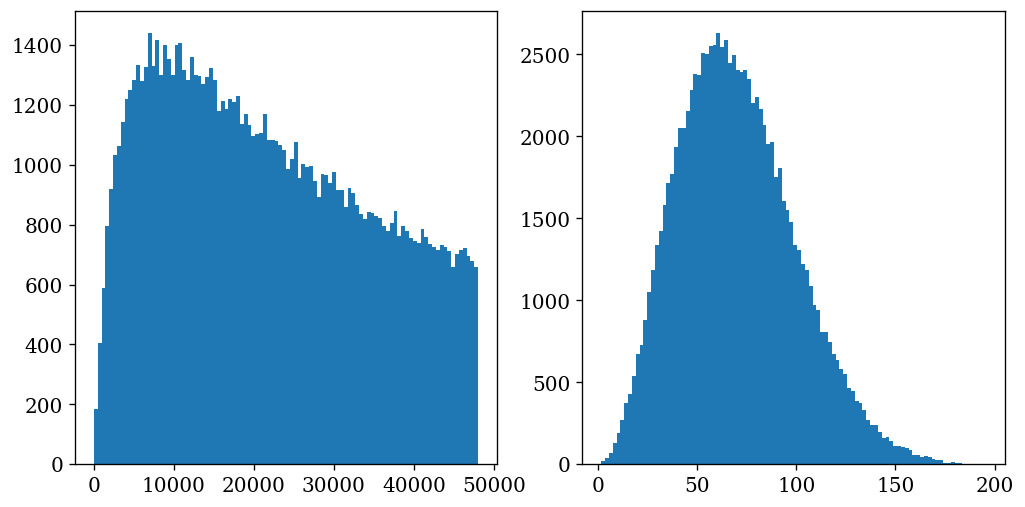

In [79]:
# what are any of these plots? 0_o

fig = plt.figure(figsize=(10, 5), dpi= 120)

ax = fig.add_subplot(121)

_,_,_ = ax.hist(np.sqrt(np.sum(genPhaseSpace[:,0:3]**2,axis=1)),bins=100)
#ax.set_yscale('log')


ax = fig.add_subplot(122)

_,_,_ = ax.hist(np.sqrt(np.sum(genPhaseSpace[:,3:6]**2,axis=1)),bins=100)
#ax.set_yscale('log')

In [80]:
# What's happening in the next few cells?

logprob = np.zeros(len(genPhaseSpace)) # initializing the log probability array
gradient = np.zeros_like(genPhaseSpace) # initializing the gradient array
acceleration = np.zeros((genPhaseSpace.shape[0],genPhaseSpace.shape[-1],genPhaseSpace.shape[-1])) # initializing the acceleration array

min_epoch = 10

for i in range(min_epoch,epochs):
    denaf.mdl.load_state_dict(torch.load("results/nfw_example/nafmodel_"+str(i)+".dict"))
    logprob_temp = np.empty(0)
    gradient_temp = np.empty(0)
    acceleration_temp = np.empty(0)
    for batch_idx, data in enumerate(test_loader):
        logprob_temp = np.concatenate((logprob_temp,denaf.density(data.cuda().float()).cpu().detach().numpy()))
        grad,acc = denaf.return_grad(data.cuda().float())
        gradient_temp = np.concatenate((gradient_temp,grad.cpu().detach().numpy().flatten()))
        acceleration_temp = np.concatenate((acceleration_temp,acc.cpu().detach().numpy().flatten()))
    gradient_temp = gradient_temp.reshape(-1,genPhaseSpace.shape[-1])
    acceleration_temp = acceleration_temp.reshape(-1,genPhaseSpace.shape[-1],genPhaseSpace.shape[-1])
            
    logprob += logprob_temp
    gradient += gradient_temp
    acceleration += acceleration_temp
    
logprob = logprob/len(range(min_epoch,epochs))
gradient = gradient/len(range(min_epoch,epochs))
acceleration = acceleration/len(range(min_epoch,epochs))

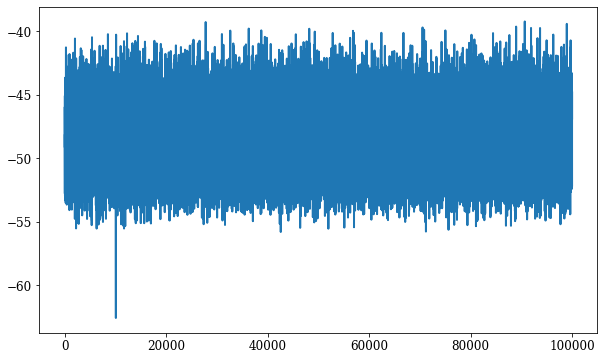

In [81]:
plt.scatter(logprob)

In [82]:
np.shape(gradient)

(100000, 6)

In [95]:
radiant = np.sqrt(gradient[:,0]**2+gradient[:,1]**2+gradient[:,2]**2)

In [96]:
radii = np.sqrt(genPhaseSpace[:,0]**2+genPhaseSpace[:,1]**2+genPhaseSpace[:,2]**2)

In [97]:
radiiSorted = radii[np.argsort(radii)]
radiantSorted = radiant[np.argsort(radii)]

(array([ 186.,  406.,  589.,  796.,  919., 1032., 1063., 1143., 1218.,
        1251., 1283., 1332., 1280., 1327., 1440., 1328., 1415., 1298.,
        1399., 1354., 1298., 1400., 1406., 1316., 1283., 1359., 1300.,
        1296., 1271., 1293., 1323., 1284., 1179., 1212., 1187., 1221.,
        1208., 1229., 1135., 1170., 1132., 1097., 1101., 1107., 1168.,
        1084., 1083., 1080., 1065., 1049.,  986., 1020., 1077.,  957.,
        1001.,  991.,  996.,  946.,  891.,  968.,  966.,  938.,  975.,
         916.,  917.,  859.,  921.,  905.,  866.,  837.,  820.,  841.,
         838.,  830.,  821.,  796.,  778.,  807.,  845.,  761.,  797.,
         780.,  754.,  746.,  739.,  784.,  758.,  735.,  724.,  716.,
         731.,  724.,  713.,  657.,  703.,  717.,  723.,  695.,  679.,
         660.]),
 array([4.31178035e+01, 5.23097096e+02, 1.00307639e+03, 1.48305568e+03,
        1.96303497e+03, 2.44301427e+03, 2.92299356e+03, 3.40297285e+03,
        3.88295214e+03, 4.36293144e+03, 4.84291073e+03, 5.

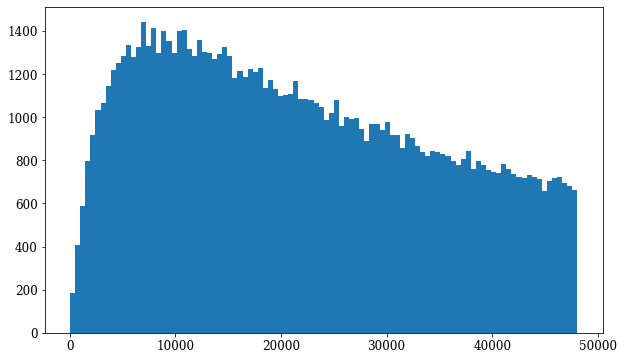

In [100]:
plt.hist(radiiSorted,100)

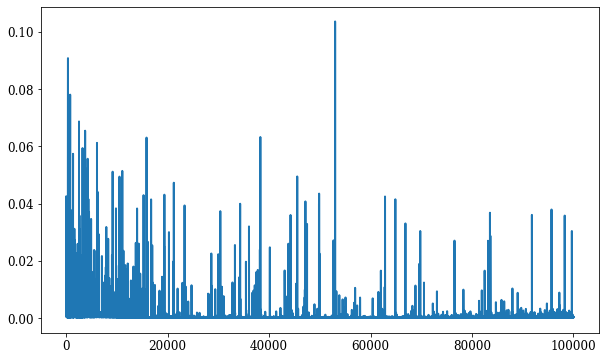

In [99]:
plt.plot(radiantSorted)

In [88]:
np.shape(acceleration)

(100000, 6, 6)

In [68]:
testpoints = np.vstack([np.linspace(-30,30,20),
                       np.linspace(-30,30,20),
                       np.linspace(-30,30,20),
                       np.linspace(-20,20,20),
                       np.linspace(-20,20,20),
                       np.linspace(-20,20,20)]).T

In [69]:
testpoints

array([[-30.        , -30.        , -30.        , -20.        ,
        -20.        , -20.        ],
       [-26.84210526, -26.84210526, -26.84210526, -17.89473684,
        -17.89473684, -17.89473684],
       [-23.68421053, -23.68421053, -23.68421053, -15.78947368,
        -15.78947368, -15.78947368],
       [-20.52631579, -20.52631579, -20.52631579, -13.68421053,
        -13.68421053, -13.68421053],
       [-17.36842105, -17.36842105, -17.36842105, -11.57894737,
        -11.57894737, -11.57894737],
       [-14.21052632, -14.21052632, -14.21052632,  -9.47368421,
         -9.47368421,  -9.47368421],
       [-11.05263158, -11.05263158, -11.05263158,  -7.36842105,
         -7.36842105,  -7.36842105],
       [ -7.89473684,  -7.89473684,  -7.89473684,  -5.26315789,
         -5.26315789,  -5.26315789],
       [ -4.73684211,  -4.73684211,  -4.73684211,  -3.15789474,
         -3.15789474,  -3.15789474],
       [ -1.57894737,  -1.57894737,  -1.57894737,  -1.05263158,
         -1.05263158,  -1.0